<a href="https://colab.research.google.com/github/utkarsh8273/MEMES_VS_NOTES/blob/master/Memes_Vs_Notes(with_CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import glob

In [4]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
path_meme = glob.glob('/content/gdrive/My Drive/Stage_2/Memes/*.jpg')
path_notes = glob.glob('/content/gdrive/My Drive/Stage_2/Notes/*.jpg')

Mounted at /content/gdrive


In [6]:
X_train = np.zeros((1000,64,64,3))
Y_train = np.zeros((1,1000))
X_val = np.zeros((300,64,64,3))
Y_val = np.zeros((1,300))
X_test = np.zeros((300,64,64,3))
Y_test = np.zeros((1,300))
k = 0
for i in path_meme :
  img = cv2.imread(i)
  img = np.array(cv2.resize(img,(64,64)))
  if k<500 :
    X_train[k,:,:,:] = np.copy(img)
    Y_train[:,k] = 1
  elif k >= 500 and k < 650:
    X_val[k-500,:] = np.copy(img)
    Y_val[:,k-500] = 1
  elif k >= 650 and k < 800 :
    X_test[k-650,:] = np.copy(img)
    Y_test[:,k-650] = 1
  else :
    break 
  k = k + 1
  print(k)
k = 500
for i in path_notes :
  img = cv2.imread(i)
  img = np.array(cv2.resize(img,(64,64)))
  if k<1000 :
    X_train[k,:,:,:] = np.copy(img)
    Y_train[:,k] = 0
  elif k>=1000 and k<1150 :
    X_val[k-850,:] = np.copy(img)
    Y_val[:,k-850] = 0
  elif k >= 1150 and k < 1300 :
    X_test[k-1000,:] = np.copy(img)
    Y_test[:,k-1000] = 0
  k = k + 1
  print(k)
shuffle_index = np.random.permutation(X_train.shape[0])
X_train,Y_train = X_train[shuffle_index,:,:,:] , Y_train[:,shuffle_index]
"""shuffle_index = np.random.permutation(X_val.shape[0])
X_val,Y_val = X_val[shuffle_index,:,:,:] , Y_val[:,shuffle_index]"""

1
1310


'shuffle_index = np.random.permutation(X_val.shape[0])\nX_val,Y_val = X_val[shuffle_index,:,:,:] , Y_val[:,shuffle_index]'

In [7]:
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
Y_val = Y_val.T
Y_train = Y_train.T
Y_test = Y_test.T
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_val = torch.from_numpy(X_val).float()
Y_val = torch.from_numpy(Y_val).float()
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()
X_train = X_train.permute(0,3,1,2)
X_val = X_val.permute(0,3,1,2)
X_test = X_test.permute(0,3,1,2)
print(X_train.size())
print(Y_train.size())
print(X_val.size())
print(Y_val.size())
print(X_test.size())
print(Y_test.size())

torch.Size([1000, 3, 64, 64])
torch.Size([1000, 1])
torch.Size([300, 3, 64, 64])
torch.Size([300, 1])
torch.Size([300, 3, 64, 64])
torch.Size([300, 1])


In [28]:
class Net(nn.Module) :
  def __init__(self) :
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3,16,33)
    self.conv2 = nn.Conv2d(16,64,11)
    self.pool  = nn.MaxPool2d(2,2)
    self.conv3 = nn.Conv2d(64,128,7)
    self.fc1   = nn.Linear(5*5*128,500)
    self.fc2   = nn.Linear(500,50)
    self.fc3   = nn.Linear(50,1)
    self.output = nn.Sigmoid()
  def forward(self,X) :
    X = F.relu(self.conv1(X))
    #print(X.size())
    X = self.conv2(X)
    #print(X.size())
    X = self.pool(X)
    #print(X.size())
    X = F.relu(self.conv3(X))
    #print(X.size())
    X = X.view(X.size(0),-1)
    #print(X.size())
    X = F.relu(self.fc1(X))
    #print(X.size())
    X = F.relu(self.fc2(X))
    #print(X.size())
    X = self.fc3(X)
    #print(X.size())
    X = self.output(X)
    #print(X.size())
    return X
net = Net()
opt = torch.optim.Adam(net.parameters(), lr=0.0001, betas=(0.999, 0.999))
criterion = nn.BCELoss()

In [29]:
def train_epoch(model, opt, criterion, batch_size, X_val,Y_val,X_train,Y_train):
    model.train()
    losses_train = []
    losses_val = []
    for i in range(0, X_train.size(0), batch_size):
        X_batch = torch.autograd.Variable(X_train[i:i + batch_size, :])
        Y_batch = torch.autograd.Variable(Y_train[i:i + batch_size, :])
        X_val = torch.autograd.Variable(X_val)
        Y_val = torch.autograd.Variable(Y_val)
        opt.zero_grad()
        y_hat = net(X_batch)
        Y_hat_val = net(X_val)
        loss = criterion(y_hat, Y_batch)
        loss_val = criterion(Y_hat_val,Y_val)
        loss.backward()
        opt.step()        
        losses_train.append(loss.data.numpy())
        losses_val.append(loss_val.data.numpy())
        print("TrainLoss : {}   ValidationLoss : {}".format(loss.data.numpy(),loss_val.data.numpy()))
    return losses_train,losses_val,loss_val,loss,y_hat,Y_hat_val

Epoch : 1
TrainLoss : 0.6924884915351868   ValidationLoss : 0.6929625272750854
TrainLoss : 0.6906477212905884   ValidationLoss : 0.6915668249130249
TrainLoss : 0.6888330578804016   ValidationLoss : 0.6903525590896606
TrainLoss : 0.6849622130393982   ValidationLoss : 0.6879649758338928
TrainLoss : 0.6760903000831604   ValidationLoss : 0.6851754188537598
TrainLoss : 0.674502968788147   ValidationLoss : 0.6812357902526855
TrainLoss : 0.6592703461647034   ValidationLoss : 0.6768434047698975
TrainLoss : 0.6592982411384583   ValidationLoss : 0.677568256855011
TrainLoss : 0.6399285793304443   ValidationLoss : 0.6706516146659851
TrainLoss : 0.6356210708618164   ValidationLoss : 0.6607216596603394
Epoch : 1  TrainLoss : 0.6356210708618164  ValidationLoss : 0.6607216596603394
Epoch : 2
TrainLoss : 0.6114511489868164   ValidationLoss : 0.6497305035591125
TrainLoss : 0.6273980140686035   ValidationLoss : 0.647685170173645
TrainLoss : 0.5935298800468445   ValidationLoss : 0.6268013119697571
TrainLo

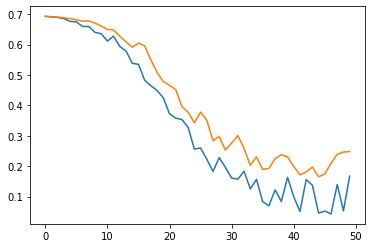

In [30]:
train_losses = []
val_losses = []
epoks = 5
for e in range(epoks):
    print("Epoch : {}".format(e+1))
    loss,loss_val,L_val,L_train,_,_ = train_epoch(net, opt, criterion,100,X_val,Y_val,X_train,Y_train)
    train_losses += loss
    val_losses += loss_val
    print("Epoch : {}  TrainLoss : {}  ValidationLoss : {}".format(e+1,L_train,L_val))
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()




In [31]:
def pred(A,Y) :
  pred = np.zeros(A.shape)
  for i in range(0,A.shape[0]) :
    if A[i,0] >= 0.50 :
      pred[i,0] = 1
  fai = np.absolute(pred - Y)
  accuracy = 1 - (np.sum(fai)/Y.shape[0])
  return accuracy*100,pred

In [32]:
Y_hat_train = net(X_train).detach().numpy()
Y_hat_val = net(X_val).detach().numpy()
Y_hat_test = net(X_test).detach().numpy()
train_acc,_ = pred(Y_hat_train,Y_train.detach().numpy())
val_acc,_ = pred(Y_hat_val,Y_val.detach().numpy())
test_acc,_ = pred(Y_hat_test,Y_test.detach().numpy())
print("Train accuracy : {}    Validation accuracy : {}    Test accuracy : {}".format(train_acc,val_acc,test_acc))

Train accuracy : 97.8    Validation accuracy : 95.0    Test accuracy : 93.66666666666667
